# Field Validation Autoencoder

In [8]:
import pandas as pd #reading dataset
import matplotlib as mpl    #plotting, visualization
import matplotlib.pyplot as plt
import tensorflow as tf #building model
from tensorflow.keras.models import Model
import numpy as np  #playing output with model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import joblib  
import json

import sys
sys.path.append('../../')   # Add parent directory to Python path
from utils.preprocessing import *
from utils.segmentation import *
from utils.plots import *


In [9]:
#load processed data
df = pd.read_csv('../../data/test/Accelerometer_ziyi_with_curb_segmented_abnormal_gereinigt.csv')
#df = df.drop(columns=['Unnamed: 0']) 
df.head(5)

,curb_scene,start_time,end_time,Acc-Z_1,Acc-Z_2,Acc-Z_3,Acc-Z_4,Acc-Z_5,Acc-Z_6,Acc-Z_7,...,Acc-Z_91,Acc-Z_92,Acc-Z_93,Acc-Z_94,Acc-Z_95,Acc-Z_96,Acc-Z_97,Acc-Z_98,Acc-Z_99,Acc-Z_100
0,0,2025-03-28 16:00:48.289,2025-03-28 16:00:48.780,8.374924,8.274368,7.814682,8.034943,7.891296,8.073242,8.173798,...,8.078033,8.020569,8.011002,8.078033,8.020569,8.020569,7.953537,7.991852,8.087616,8.039734
1,0,2025-03-28 16:00:48.785,2025-03-28 16:00:49.277,8.030151,7.977478,8.020569,8.054092,8.020569,8.020569,7.987061,...,7.441177,7.259216,7.584824,7.536942,7.278366,7.254425,7.503433,7.704544,7.781158,7.742844
2,0,2025-03-28 16:00:49.284,2025-03-28 16:00:49.773,7.517792,7.723694,7.939178,7.718903,7.733276,7.508209,7.498642,...,6.689407,6.689407,6.459549,6.234497,5.750870,5.477936,5.722137,6.766022,7.991852,8.384491
3,0,2025-03-28 16:00:49.778,2025-03-28 16:00:50.270,8.633499,9.428360,10.046066,8.925583,7.010223,7.082046,6.885727,...,6.689407,8.609543,9.916779,8.930374,8.427597,8.173798,8.384491,7.412445,7.776367,8.011002
4,0,2025-03-28 16:00:50.275,2025-03-28 16:00:50.766,10.960663,10.577591,9.801865,7.599197,6.493073,8.561661,8.892059,...,9.284714,9.232040,8.437164,8.576035,9.030930,9.514557,9.265564,9.686935,10.113113,9.428360


In [10]:
# prepare data for model
# standardize data
scaler = StandardScaler()
test_data_scaled = scaler.fit_transform(df.iloc[:, 3:])
# Convert the scaled data back to DataFrames for further processing
test_data_scaled = pd.DataFrame(test_data_scaled, columns=df.columns[3:])
# Add the 'curb_scene', 'start_time', and 'end_time' columns back to the scaled DataFrames
test_data_scaled['curb_scene'] = df['curb_scene']
test_data_scaled['start_time'] = df['start_time']
test_data_scaled['end_time'] = df['end_time']
# Filter and slice the data
test_data_scaled_normal = test_data_scaled[test_data_scaled['curb_scene'] == 0].iloc[:, :-3]
test_data_scaled_abnormal = test_data_scaled[test_data_scaled['curb_scene'] == 1].iloc[:, :-3]
# Cast to float32
test_data_scaled_normal = test_data_scaled_normal.astype(np.float32)
test_data_scaled_abnormal = test_data_scaled_abnormal.astype(np.float32)
test_data_scaled_normal.shape, test_data_scaled_abnormal.shape



((2427, 100), (259, 100))

In [11]:
# Make predictions using autoencoder
autoencoder = tf.keras.models.load_model('../../models/autoencoder_best.keras')
with open('../../models/autoencoder_thresholds.json', 'r') as f:
    loaded_thresholds = json.load(f)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


C:\Users\liuzi\AppData\Local\Temp\ipykernel_11560\2162391532.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


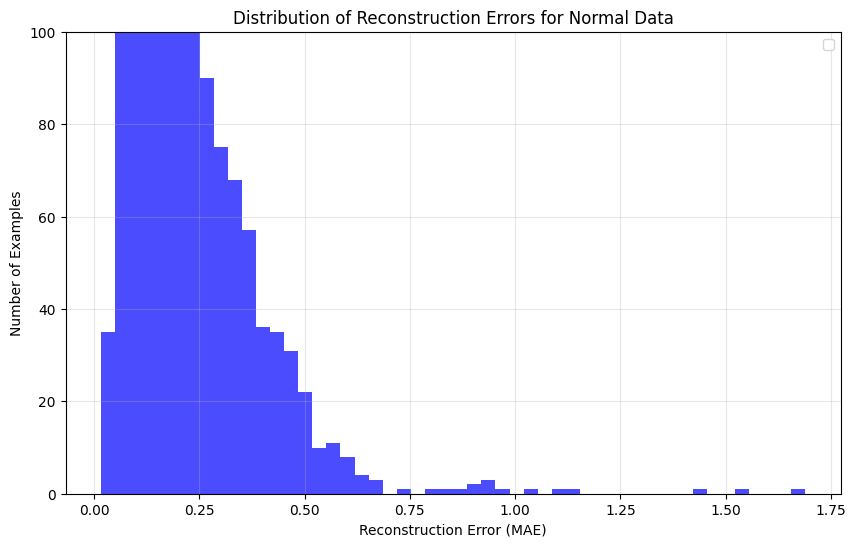

In [12]:
# Plot reconstruction error distribution for normal training data
reconstructions_normal = autoencoder.predict(test_data_scaled_normal)
train_loss_normal = tf.keras.losses.mae(reconstructions_normal, test_data_scaled_normal)

plt.figure(figsize=(10, 6))
plt.hist(train_loss_normal, bins=50, color='blue', alpha=0.7)

plt.title('Distribution of Reconstruction Errors for Normal Data', fontsize=12)
plt.xlabel('Reconstruction Error (MAE)', fontsize=10)
plt.ylabel('Number of Examples', fontsize=10)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


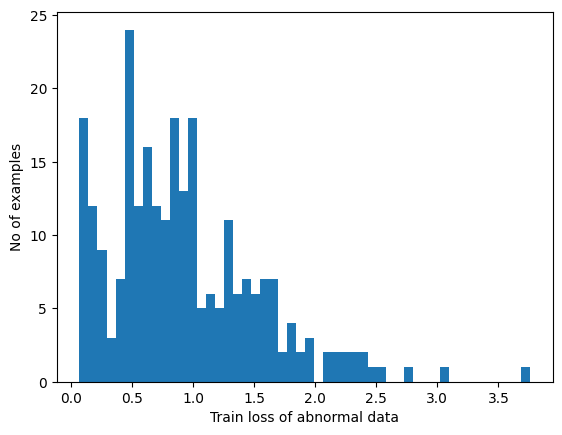

In [13]:
#Plot the reconstruction error on abnormal data from the training set
reconstructions_abnormal = autoencoder.predict(test_data_scaled_abnormal)
train_loss_abnormal = tf.keras.losses.mae(reconstructions_abnormal, test_data_scaled_abnormal)

plt.hist(train_loss_abnormal[None,:], bins=50)
plt.xlabel("Train loss of abnormal data")
plt.ylabel("No of examples")
plt.show()

In [19]:
threshold = loaded_thresholds['low_threshold']

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


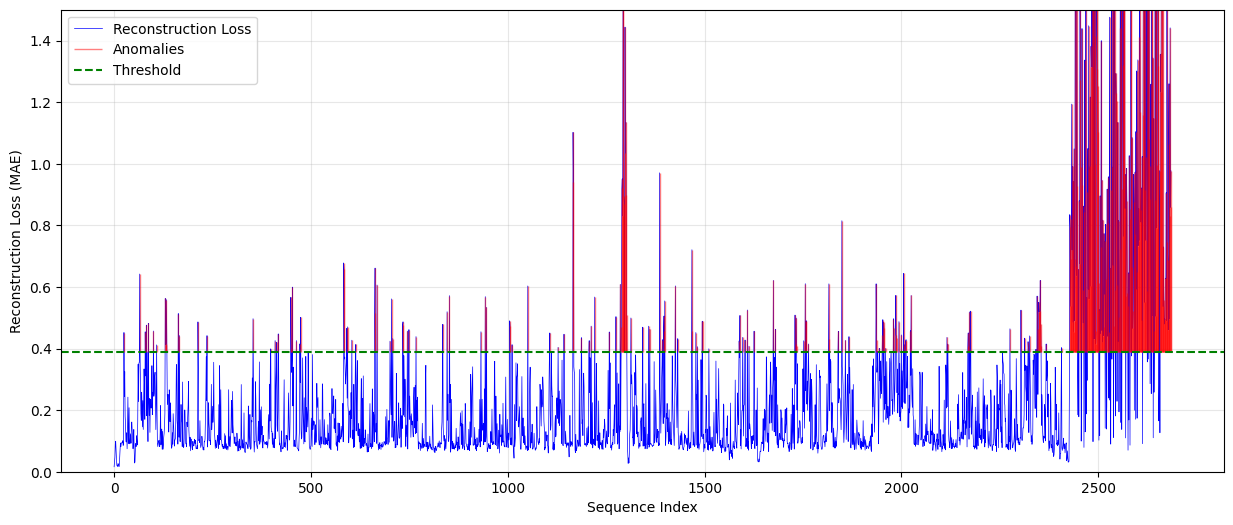

In [20]:
loss, anomaly_indices = plot_anomaly_reconstruction_loss(
    test_data_scaled_normal,
    test_data_scaled_abnormal,
    autoencoder,
    threshold
)

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


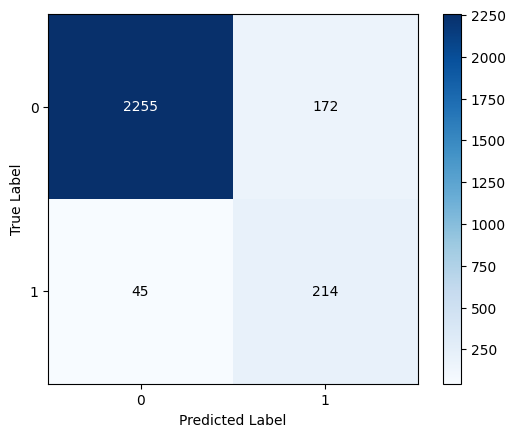

              precision    recall  f1-score   support

  Normal (0)      0.980     0.929     0.954      2427
Abnormal (1)      0.554     0.826     0.664       259

    accuracy                          0.919      2686
   macro avg      0.767     0.878     0.809      2686
weighted avg      0.939     0.919     0.926      2686



In [21]:
# Create binary labels and combine data
true_labels = np.concatenate([np.zeros(len(test_data_scaled_normal)), 
                        np.ones(len(test_data_scaled_abnormal))])
# Concatenate the normal and abnormal data
X_test = pd.concat([test_data_scaled_normal, test_data_scaled_abnormal])

# Get predictions using threshold
reconstructions_error = autoencoder.predict(X_test)
predictions = (tf.keras.losses.mae(reconstructions_error, X_test).numpy() > threshold).astype(int)

plot_confusion_matrix(true_labels, predictions)